# Generative Adversarial Networks (GANs) menggunakan JAX dan Flax

Generative Adversarial Networks (GANs) adalah kelas kerangka kerja pembelajaran mesin yang dirancang oleh Ian Goodfellow dan rekan-rekannya pada tahun 2014. GAN terdiri dari dua jaringan saraf, yaitu **Generator** dan **Discriminator**, yang bersaing satu sama lain dalam permainan zero-sum.

## 1. Latar Belakang Matematis

Proses pelatihan GAN sering digambarkan sebagai permainan minimax di mana Generator ($G$) mencoba menghasilkan sampel realistis untuk menipu Discriminator ($D$), dan Discriminator mencoba membedakan antara data asli dan sampel palsu yang dihasilkan oleh Generator.

Fungsi objektif utamanya adalah **Value Function** $V(D, G)$:

$$\min_G \max_D V(D, G) = \mathbb{E}_{x \sim p_{\text{data}}(x)}[\log D(x)] + \mathbb{E}_{z \sim p_z(z)}[\log(1 - D(G(z)))]$$

Di mana:
- $x$: sebuah gambar asli dari data pelatihan.
- $z$: sebuah vektor noise acak dari distribusi prior (misalnya, Gaussian).
- $G(z)$: representasi data dari generator.
- $D(x)$: estimasi discriminator tentang probabilitas bahwa contoh data asli $x$ adalah asli.

### Langkah Pelatihan
1. **Perbarui Discriminator**: Maksimalkan probabilitas penempatan label yang benar baik untuk contoh pelatihan maupun sampel dari $G$.
2. **Perbarui Generator**: Minimalkan $\log(1 - D(G(z)))$. Dalam praktiknya, kita sering kali memaksimalkan $\log D(G(z))$ untuk memberikan gradien yang lebih baik di awal pelatihan.

## 2. Persiapan dan Impor

Pertama, mari kita impor pustaka yang diperlukan. Kita akan menggunakan JAX untuk komputasi backend, Flax NNX untuk definisi model, dan Optax untuk optimasi.

In [1]:
import jax
import jax.numpy as jnp
from flax import nnx
import matplotlib.pyplot as plt
import sys, os
import numpy as np
import time as timer
from tqdm import tqdm
import grain.python as grain
from sklearn.datasets import fetch_openml
import optax

# Add parent directory to path to import utils
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import viz_utils as vu
import model_utils as mu

## 3. Konfigurasi dan Hiperparameter

In [ ]:
# Define constants
DATA_DIR = "../data"
MODEL_DIR = "../models" 

BATCH_SIZE = 128
NUM_EPOCH = 50
NC = 1 # num channels
NZ = 100 # num latent variables
LR = 2e-4 # learning rate
BETA1 = 0.5 # beta1 for Adam optimizer
NVIZ = 64

DATASET = 'mnist'
mname = "gan"
checkpoint_dir = os.path.join(MODEL_DIR, f"{mname}_{DATASET}_z{NZ}")
sample_dir = os.path.join(checkpoint_dir, "samples")

for d in [checkpoint_dir, sample_dir]:
    if not os.path.exists(d):
        os.makedirs(d)
        print(f'The new directory {d} has been created')

## 4. Pemuatan Data

Kita memuat dataset MNIST menggunakan `fetch_openml` dari Scikit-Learn dan menggunakan `grain` dari Google untuk pemuatan data yang efisien.

In [3]:
print("Loading MNIST via OpenML (may take a minute)...Found locally if cache exists")
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='liac-arff')
X_all, y_all = mnist.data, mnist.target.astype(np.int32)

# Split into train and test (60k / 10k)
X_train_all, X_test_all = X_all[:60000], X_all[60000:]
y_train_all, y_test_all = y_all[:60000], y_all[60000:]

class MNISTSource(grain.RandomAccessDataSource):
    def __init__(self, images, labels):
        self._images = images
        self._labels = labels
        
    def __len__(self):
        return len(self._images)
        
    def __getitem__(self, index):
        # Reshape to (1, 28, 28) and normalize to [-1, 1]
        image = (self._images[index].reshape(1, 28, 28).astype(np.float32) / 255.0) * 2.0 - 1.0
        label = self._labels[index]
        return {'image': image, 'label': label}

def create_loader(data_source, batch_size, shuffle=False, seed=0):
    sampler = grain.IndexSampler(
        num_records=len(data_source),
        shard_options=grain.NoSharding(),
        shuffle=shuffle,
        num_epochs=1,
        seed=seed,
    )
    dataloader = grain.DataLoader(
        data_source=data_source,
        sampler=sampler,
        worker_count=0,
    )
    
    class BatchIterator:
        def __init__(self, loader, batch_size, num_records):
            self.loader = loader
            self.batch_size = batch_size
            self.num_records = num_records
        
        def __len__(self):
            return (self.num_records + self.batch_size - 1) // self.batch_size

        def __iter__(self):
            batch_images, batch_labels = [], []
            for record in self.loader:
                batch_images.append(record['image'])
                batch_labels.append(record['label'])
                if len(batch_images) == self.batch_size:
                    yield np.stack(batch_images), np.array(batch_labels)
                    batch_images, batch_labels = [], []
            if batch_images:
                 yield np.stack(batch_images), np.array(batch_labels)
    
    return BatchIterator(dataloader, batch_size, len(data_source))

train_loader = create_loader(MNISTSource(X_train_all, y_train_all), BATCH_SIZE, shuffle=True, seed=42)

Loading MNIST via OpenML (may take a minute)...Found locally if cache exists


## 5. Arsitektur Model

Baik Generator maupun Discriminator adalah Multi-Layer Perceptrons (MLPs) sebagaimana didefinisikan dalam makalah asli GAN untuk dataset sederhana seperti MNIST.

In [4]:
class Generator(nnx.Module):
    def __init__(self, input_size=100, output_size=784, rngs: nnx.Rngs = None):
        self.fc1 = nnx.Linear(input_size, 128, rngs=rngs)
        self.fc2 = nnx.Linear(128, 256, rngs=rngs)
        self.bn2 = nnx.BatchNorm(256, rngs=rngs)
        self.fc3 = nnx.Linear(256, 512, rngs=rngs)
        self.bn3 = nnx.BatchNorm(512, rngs=rngs)
        self.fc4 = nnx.Linear(512, 1024, rngs=rngs)
        self.bn4 = nnx.BatchNorm(1024, rngs=rngs)
        self.fc5 = nnx.Linear(1024, output_size, rngs=rngs)
    
    def __call__(self, z):
        h = nnx.leaky_relu(self.fc1(z), negative_slope=0.2)
        h = nnx.leaky_relu(self.bn2(self.fc2(h)), negative_slope=0.2)
        h = nnx.leaky_relu(self.bn3(self.fc3(h)), negative_slope=0.2)
        h = nnx.leaky_relu(self.bn4(self.fc4(h)), negative_slope=0.2)
        h = nnx.tanh(self.fc5(h))
        return h.reshape(h.shape[0], NC, 28, 28)

class Discriminator(nnx.Module):
    def __init__(self, input_size=784, num_classes=1, rngs: nnx.Rngs = None):
        self.fc1 = nnx.Linear(input_size, 512, rngs=rngs)
        self.fc2 = nnx.Linear(512, 256, rngs=rngs)
        self.fc3 = nnx.Linear(256, num_classes, rngs=rngs)
        
    def __call__(self, x):
        x = x.reshape(x.shape[0], -1) 
        h = nnx.leaky_relu(self.fc1(x), negative_slope=0.2)
        h = nnx.leaky_relu(self.fc2(h), negative_slope=0.2)
        return nnx.sigmoid(self.fc3(h)).flatten()

## 6. Fungsi Pelatihan

Kita mendefinisikan fungsi loss dan langkah pelatihan yang dikompilasi JIT.

In [6]:
def binary_cross_entropy(logits, labels):
    epsilon = 1e-12
    logits = jnp.clip(logits, epsilon, 1.0 - epsilon)
    return -jnp.mean(labels * jnp.log(logits) + (1 - labels) * jnp.log(1 - logits))

@nnx.jit
def train_step_D(netD, netG, optimizerD, real_x, noise):
    fake_x = netG(noise)
    def loss_fn(netD):
        real_pred = netD(real_x)
        fake_pred = netD(fake_x)
        errD = binary_cross_entropy(real_pred, jnp.ones_like(real_pred)) + \
               binary_cross_entropy(fake_pred, jnp.zeros_like(fake_pred))
        return errD, (real_pred, fake_pred)
    (loss, (real_p, fake_p)), grads = nnx.value_and_grad(loss_fn, has_aux=True)(netD)
    optimizerD.update(netD, grads)
    return loss, jnp.mean(real_p), jnp.mean(fake_p)

@nnx.jit
def train_step_G(netD, netG, optimizerG, noise):
    def loss_fn(netG):
        fake_x = netG(noise)
        preds = netD(fake_x)
        return binary_cross_entropy(preds, jnp.ones_like(preds)), preds
    (loss, preds), grads = nnx.value_and_grad(loss_fn, has_aux=True)(netG)
    optimizerG.update(netG, grads)
    return loss, jnp.mean(preds)

## 7. Loop Pelatihan

Sekarang kita menginisialisasi model dan menjalankan loop pelatihan.

Epoch 1: 100%|██████████| 469/469 [00:06<00:00, 75.32batch/s, Dx=0.5979, Loss_D=1.2641, Loss_G=1.0439]


Epoch 1 finished in 6.23s


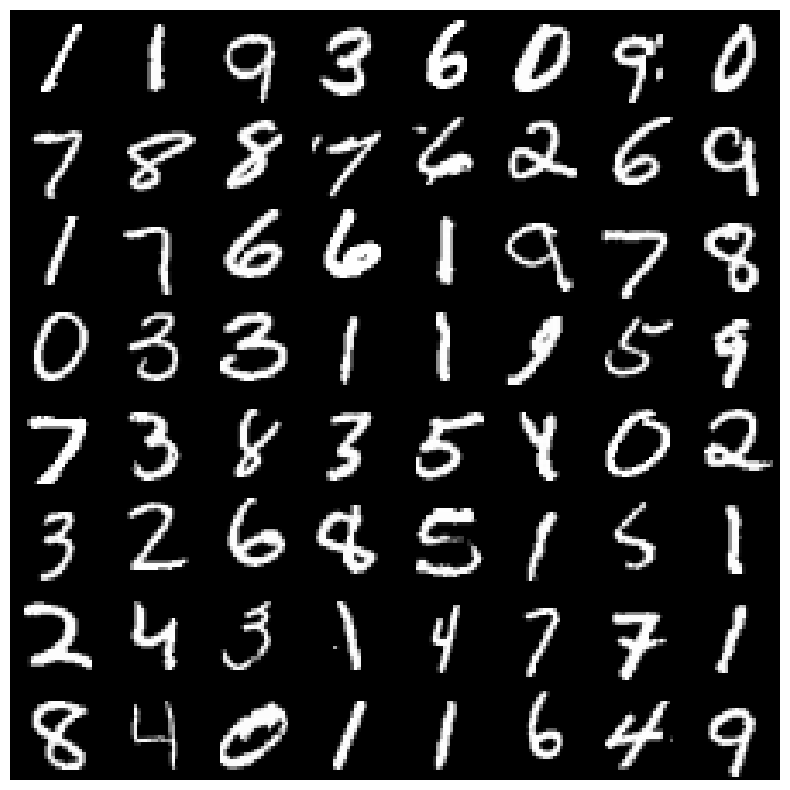

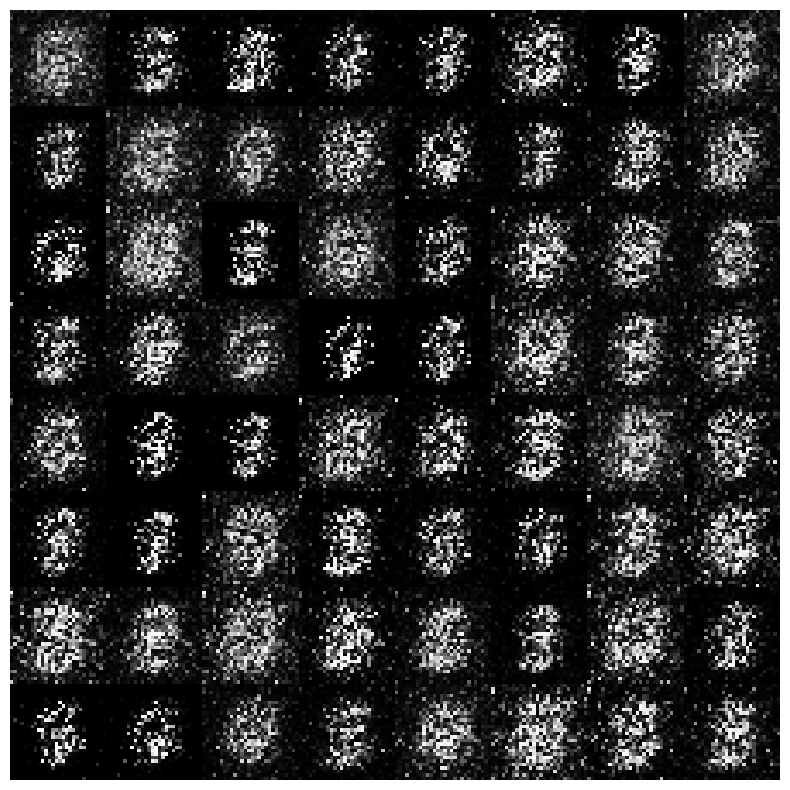

Model disimpan ke /Users/mghifary/Work/Code/AI/IF5281/jax/models/gan_mnist_z100/epoch_1.safetensors
Model disimpan ke /Users/mghifary/Work/Code/AI/IF5281/jax/models/gan_mnist_z100/generator/epoch_1.safetensors
Model disimpan ke /Users/mghifary/Work/Code/AI/IF5281/jax/models/gan_mnist_z100/discriminator/epoch_1.safetensors
 --- Models stored ---


Epoch 2: 100%|██████████| 469/469 [00:05<00:00, 84.40batch/s, Dx=0.5575, Loss_D=1.3727, Loss_G=0.9148]


Epoch 2 finished in 5.56s


Epoch 3: 100%|██████████| 469/469 [00:05<00:00, 87.31batch/s, Dx=0.6065, Loss_D=1.2485, Loss_G=1.0238]


Epoch 3 finished in 5.37s


Epoch 4: 100%|██████████| 469/469 [00:05<00:00, 86.64batch/s, Dx=0.4012, Loss_D=1.4128, Loss_G=0.5163]


Epoch 4 finished in 5.41s


Epoch 5: 100%|██████████| 469/469 [00:05<00:00, 86.67batch/s, Dx=0.5804, Loss_D=1.1918, Loss_G=0.8630]


Epoch 5 finished in 5.41s


Epoch 6: 100%|██████████| 469/469 [00:05<00:00, 84.96batch/s, Dx=0.5339, Loss_D=1.2317, Loss_G=0.8369]


Epoch 6 finished in 5.52s


Epoch 7: 100%|██████████| 469/469 [00:05<00:00, 89.54batch/s, Dx=0.5643, Loss_D=1.2469, Loss_G=0.8885]


Epoch 7 finished in 5.24s


Epoch 8: 100%|██████████| 469/469 [00:05<00:00, 89.01batch/s, Dx=0.7048, Loss_D=1.2940, Loss_G=1.1813]


Epoch 8 finished in 5.27s


Epoch 9: 100%|██████████| 469/469 [00:05<00:00, 88.61batch/s, Dx=0.5589, Loss_D=1.2412, Loss_G=0.8188]


Epoch 9 finished in 5.29s


Epoch 10: 100%|██████████| 469/469 [00:05<00:00, 88.65batch/s, Dx=0.5721, Loss_D=1.2449, Loss_G=0.8811]


Epoch 10 finished in 5.29s


Epoch 11: 100%|██████████| 469/469 [00:05<00:00, 87.53batch/s, Dx=0.6159, Loss_D=1.3250, Loss_G=0.9833]


Epoch 11 finished in 5.36s


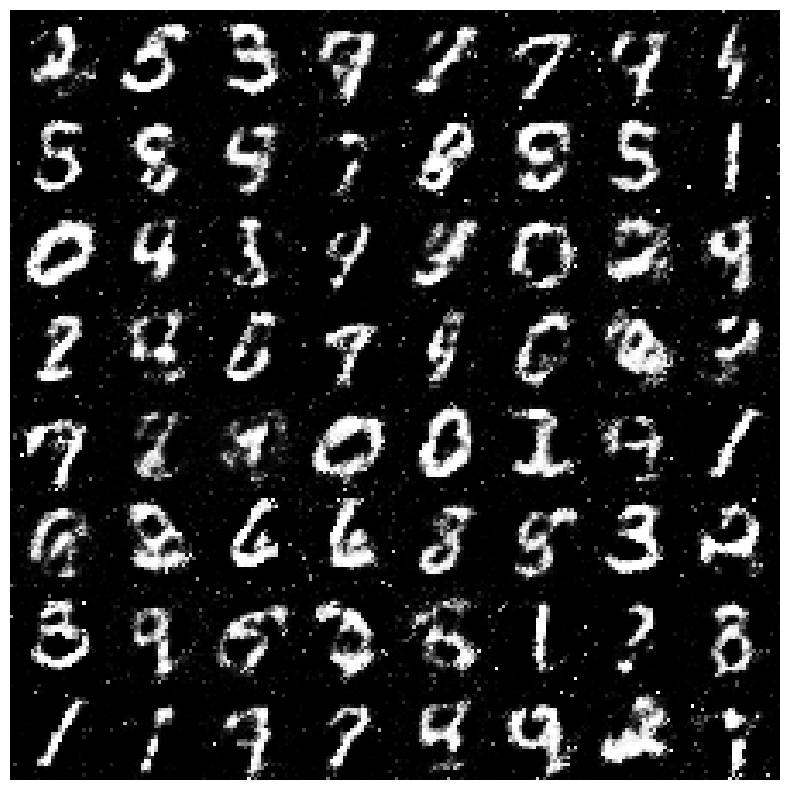

Model disimpan ke /Users/mghifary/Work/Code/AI/IF5281/jax/models/gan_mnist_z100/epoch_11.safetensors
Model disimpan ke /Users/mghifary/Work/Code/AI/IF5281/jax/models/gan_mnist_z100/generator/epoch_11.safetensors
Model disimpan ke /Users/mghifary/Work/Code/AI/IF5281/jax/models/gan_mnist_z100/discriminator/epoch_11.safetensors
 --- Models stored ---


Epoch 12: 100%|██████████| 469/469 [00:05<00:00, 88.20batch/s, Dx=0.5661, Loss_D=1.3266, Loss_G=1.0035]


Epoch 12 finished in 5.32s


Epoch 13: 100%|██████████| 469/469 [00:05<00:00, 87.06batch/s, Dx=0.5903, Loss_D=1.2797, Loss_G=0.9461]


Epoch 13 finished in 5.39s


Epoch 14: 100%|██████████| 469/469 [00:05<00:00, 87.51batch/s, Dx=0.5214, Loss_D=1.2900, Loss_G=0.8179]


Epoch 14 finished in 5.36s


Epoch 15: 100%|██████████| 469/469 [00:05<00:00, 88.79batch/s, Dx=0.5419, Loss_D=1.2680, Loss_G=0.8279]


Epoch 15 finished in 5.28s


Epoch 16: 100%|██████████| 469/469 [00:05<00:00, 87.78batch/s, Dx=0.5898, Loss_D=1.3099, Loss_G=0.9703]


Epoch 16 finished in 5.34s


Epoch 17: 100%|██████████| 469/469 [00:05<00:00, 89.20batch/s, Dx=0.4904, Loss_D=1.2645, Loss_G=0.7313]


Epoch 17 finished in 5.26s


Epoch 18: 100%|██████████| 469/469 [00:05<00:00, 87.10batch/s, Dx=0.5899, Loss_D=1.2591, Loss_G=0.8912]


Epoch 18 finished in 5.39s


Epoch 19: 100%|██████████| 469/469 [00:05<00:00, 85.32batch/s, Dx=0.6743, Loss_D=1.3923, Loss_G=1.1415]


Epoch 19 finished in 5.50s


Epoch 20: 100%|██████████| 469/469 [00:05<00:00, 84.86batch/s, Dx=0.5797, Loss_D=1.2616, Loss_G=0.8683]


Epoch 20 finished in 5.53s


Epoch 21: 100%|██████████| 469/469 [00:05<00:00, 80.81batch/s, Dx=0.6004, Loss_D=1.2742, Loss_G=1.0242]


Epoch 21 finished in 5.80s


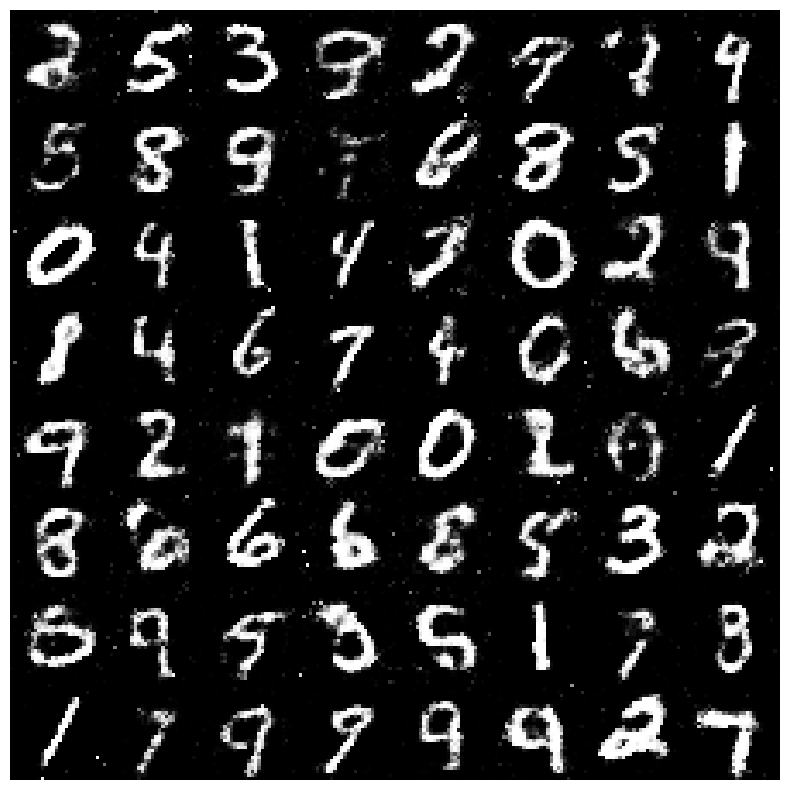

Model disimpan ke /Users/mghifary/Work/Code/AI/IF5281/jax/models/gan_mnist_z100/epoch_21.safetensors
Model disimpan ke /Users/mghifary/Work/Code/AI/IF5281/jax/models/gan_mnist_z100/generator/epoch_21.safetensors
Model disimpan ke /Users/mghifary/Work/Code/AI/IF5281/jax/models/gan_mnist_z100/discriminator/epoch_21.safetensors
 --- Models stored ---


Epoch 22: 100%|██████████| 469/469 [00:05<00:00, 80.86batch/s, Dx=0.5181, Loss_D=1.2834, Loss_G=0.8062]


Epoch 22 finished in 5.80s


Epoch 23: 100%|██████████| 469/469 [00:05<00:00, 84.77batch/s, Dx=0.5267, Loss_D=1.2823, Loss_G=0.7986]


Epoch 23 finished in 5.53s


Epoch 24: 100%|██████████| 469/469 [00:05<00:00, 85.82batch/s, Dx=0.5265, Loss_D=1.2610, Loss_G=0.8218]


Epoch 24 finished in 5.47s


Epoch 25: 100%|██████████| 469/469 [00:05<00:00, 87.59batch/s, Dx=0.5423, Loss_D=1.2975, Loss_G=0.8175]


Epoch 25 finished in 5.36s


Epoch 26: 100%|██████████| 469/469 [00:05<00:00, 87.74batch/s, Dx=0.4309, Loss_D=1.3380, Loss_G=0.5443]


Epoch 26 finished in 5.35s


Epoch 27: 100%|██████████| 469/469 [00:05<00:00, 86.63batch/s, Dx=0.5117, Loss_D=1.2887, Loss_G=0.7489]


Epoch 27 finished in 5.41s


Epoch 28: 100%|██████████| 469/469 [00:05<00:00, 83.76batch/s, Dx=0.5657, Loss_D=1.2562, Loss_G=0.8802]


Epoch 28 finished in 5.60s


Epoch 29: 100%|██████████| 469/469 [00:05<00:00, 85.70batch/s, Dx=0.4926, Loss_D=1.2990, Loss_G=0.7472]


Epoch 29 finished in 5.47s


Epoch 30: 100%|██████████| 469/469 [00:05<00:00, 85.40batch/s, Dx=0.6034, Loss_D=1.2988, Loss_G=1.0199]


Epoch 30 finished in 5.49s


Epoch 31: 100%|██████████| 469/469 [00:05<00:00, 80.42batch/s, Dx=0.5201, Loss_D=1.2650, Loss_G=0.7510]


Epoch 31 finished in 5.83s


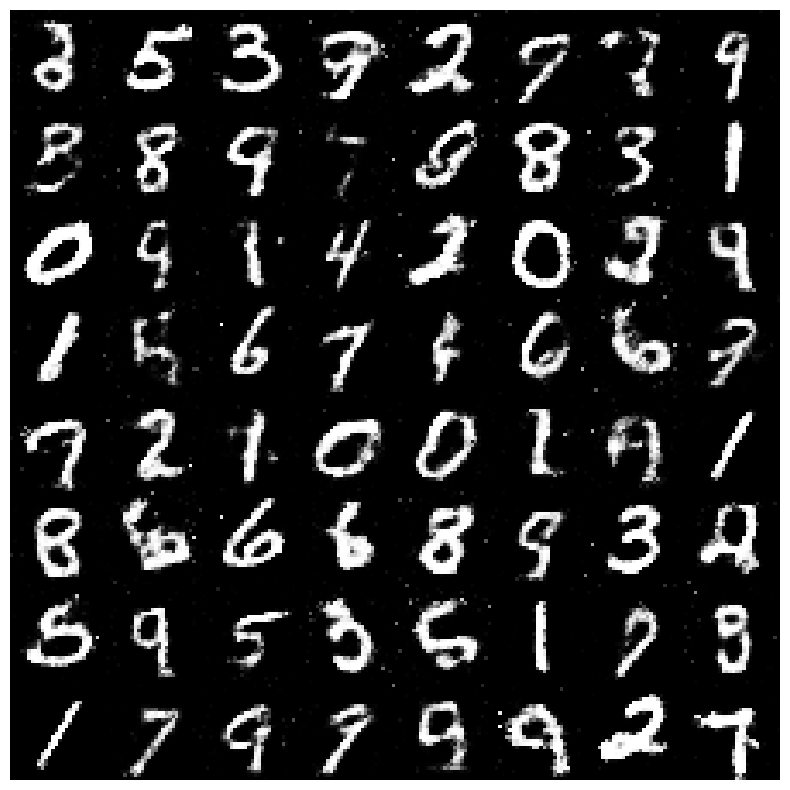

Model disimpan ke /Users/mghifary/Work/Code/AI/IF5281/jax/models/gan_mnist_z100/epoch_31.safetensors
Model disimpan ke /Users/mghifary/Work/Code/AI/IF5281/jax/models/gan_mnist_z100/generator/epoch_31.safetensors
Model disimpan ke /Users/mghifary/Work/Code/AI/IF5281/jax/models/gan_mnist_z100/discriminator/epoch_31.safetensors
 --- Models stored ---


Epoch 32: 100%|██████████| 469/469 [00:05<00:00, 88.42batch/s, Dx=0.5079, Loss_D=1.2913, Loss_G=0.7567]


Epoch 32 finished in 5.31s


Epoch 33: 100%|██████████| 469/469 [00:05<00:00, 89.11batch/s, Dx=0.5201, Loss_D=1.2832, Loss_G=0.7990]


Epoch 33 finished in 5.26s


Epoch 34: 100%|██████████| 469/469 [00:05<00:00, 86.28batch/s, Dx=0.4771, Loss_D=1.2625, Loss_G=0.7512]


Epoch 34 finished in 5.44s


Epoch 35: 100%|██████████| 469/469 [00:05<00:00, 85.79batch/s, Dx=0.5653, Loss_D=1.2687, Loss_G=0.8965]


Epoch 35 finished in 5.47s


Epoch 36: 100%|██████████| 469/469 [00:05<00:00, 85.70batch/s, Dx=0.5436, Loss_D=1.2564, Loss_G=0.8598]


Epoch 36 finished in 5.47s


Epoch 37: 100%|██████████| 469/469 [00:05<00:00, 83.61batch/s, Dx=0.5421, Loss_D=1.2871, Loss_G=0.8530]


Epoch 37 finished in 5.61s


Epoch 38: 100%|██████████| 469/469 [00:05<00:00, 84.53batch/s, Dx=0.5919, Loss_D=1.2686, Loss_G=0.9541]


Epoch 38 finished in 5.55s


Epoch 39: 100%|██████████| 469/469 [00:05<00:00, 85.59batch/s, Dx=0.5452, Loss_D=1.3068, Loss_G=0.8734]


Epoch 39 finished in 5.48s


Epoch 40: 100%|██████████| 469/469 [00:05<00:00, 88.39batch/s, Dx=0.5380, Loss_D=1.2533, Loss_G=0.8188]


Epoch 40 finished in 5.31s


Epoch 41: 100%|██████████| 469/469 [00:05<00:00, 86.93batch/s, Dx=0.5797, Loss_D=1.2272, Loss_G=0.8460]


Epoch 41 finished in 5.40s


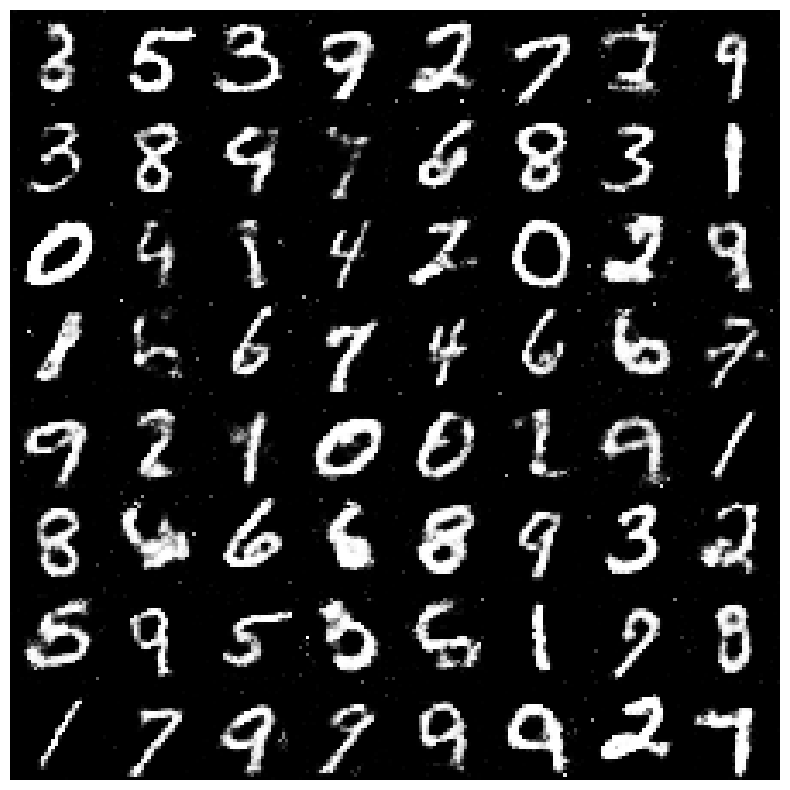

Model disimpan ke /Users/mghifary/Work/Code/AI/IF5281/jax/models/gan_mnist_z100/epoch_41.safetensors
Model disimpan ke /Users/mghifary/Work/Code/AI/IF5281/jax/models/gan_mnist_z100/generator/epoch_41.safetensors
Model disimpan ke /Users/mghifary/Work/Code/AI/IF5281/jax/models/gan_mnist_z100/discriminator/epoch_41.safetensors
 --- Models stored ---


Epoch 42: 100%|██████████| 469/469 [00:05<00:00, 85.68batch/s, Dx=0.4884, Loss_D=1.2880, Loss_G=0.7156]


Epoch 42 finished in 5.47s


Epoch 43: 100%|██████████| 469/469 [00:05<00:00, 82.62batch/s, Dx=0.4871, Loss_D=1.3019, Loss_G=0.8106]


Epoch 43 finished in 5.68s


Epoch 44: 100%|██████████| 469/469 [00:06<00:00, 77.22batch/s, Dx=0.5270, Loss_D=1.2617, Loss_G=0.7789]


Epoch 44 finished in 6.07s


Epoch 45: 100%|██████████| 469/469 [00:05<00:00, 83.75batch/s, Dx=0.4306, Loss_D=1.3516, Loss_G=0.5989]


Epoch 45 finished in 5.60s


Epoch 46: 100%|██████████| 469/469 [00:05<00:00, 88.56batch/s, Dx=0.6147, Loss_D=1.2667, Loss_G=1.1178]


Epoch 46 finished in 5.30s


Epoch 47: 100%|██████████| 469/469 [00:05<00:00, 90.35batch/s, Dx=0.5038, Loss_D=1.2747, Loss_G=0.8411] 


Epoch 47 finished in 5.19s


Epoch 48: 100%|██████████| 469/469 [00:05<00:00, 91.89batch/s, Dx=0.4538, Loss_D=1.3211, Loss_G=0.7348]


Epoch 48 finished in 5.11s


Epoch 49: 100%|██████████| 469/469 [00:05<00:00, 90.49batch/s, Dx=0.5109, Loss_D=1.2415, Loss_G=0.7741]


Epoch 49 finished in 5.18s


Epoch 50: 100%|██████████| 469/469 [00:05<00:00, 85.39batch/s, Dx=0.5169, Loss_D=1.2373, Loss_G=0.7284]


Epoch 50 finished in 5.49s
 -- Storing final checkpoints --
Model disimpan ke /Users/mghifary/Work/Code/AI/IF5281/jax/models/gan_mnist_z100/epoch_50.safetensors
Model disimpan ke /Users/mghifary/Work/Code/AI/IF5281/jax/models/gan_mnist_z100/generator/epoch_50.safetensors
Model disimpan ke /Users/mghifary/Work/Code/AI/IF5281/jax/models/gan_mnist_z100/discriminator/epoch_50.safetensors


In [7]:
rngs = nnx.Rngs(0)
netG = Generator(input_size=NZ, output_size=28*28, rngs=rngs)
netD = Discriminator(input_size=28*28, num_classes=1, rngs=rngs)

optimizerG = nnx.Optimizer(netG, optax.adam(LR, b1=BETA1), wrt=nnx.Param)
optimizerD = nnx.Optimizer(netD, optax.adam(LR, b1=BETA1), wrt=nnx.Param)

fixed_latent = jax.random.normal(jax.random.PRNGKey(42), (64, NZ))
step_rng = jax.random.PRNGKey(0)

for epoch in range(NUM_EPOCH):
    start_t = timer.time()
    with tqdm(train_loader, unit="batch", desc=f"Epoch {epoch+1}") as tepoch:
        for batch_idx, (real_x, _) in enumerate(tepoch):
            step_rng, rng_d, rng_g = jax.random.split(step_rng, 3)
            
            noise_d = jax.random.normal(rng_d, (real_x.shape[0], NZ))
            errD, D_x, D_G_z1 = train_step_D(netD, netG, optimizerD, real_x, noise_d)
            
            noise_g = jax.random.normal(rng_g, (real_x.shape[0], NZ))
            errG, D_G_z2 = train_step_G(netD, netG, optimizerG, noise_g)
            
            if batch_idx % 100 == 0:
                tepoch.set_postfix(Loss_D=f"{errD:.4f}", Loss_G=f"{errG:.4f}", Dx=f"{D_x:.4f}")
    
    print(f'Epoch {epoch+1} finished in {timer.time() - start_t:.2f}s')

    # Save Real Samples (Only once)
    if epoch == 0:
        vutils_real = real_x[:NVIZ] if real_x.shape[0] >= NVIZ else real_x
        # real_x is (B, 1, 28, 28)
        grid_real = vu.set_grid(vutils_real, num_cells=64) # NVIZ used in original was 512, let's use 64
        plt.figure(figsize=(10, 10))
        plt.imshow(np.transpose(np.array(vu.normalize(grid_real, 0, 1)), (1, 2, 0)), cmap='gray')
        plt.axis('off')
        plt.show()
        plt.savefig(os.path.join(sample_dir, 'real_samples.jpg'), bbox_inches='tight')
        plt.close()

    if epoch % 10 != 0:
        continue

    # Save Fake Samples
    fake_samples = netG(fixed_latent)
    # fake_samples is (B, 1, 28, 28)
    grid_fake = vu.set_grid(fake_samples, num_cells=64)
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(np.array(vu.normalize(grid_fake, 0, 1)), (1, 2, 0)), cmap='gray')
    plt.axis('off')
    plt.savefig(os.path.join(sample_dir, f'fake_samples_epoch-{epoch+1}.jpg'), bbox_inches='tight')
    plt.show()
    plt.close()
    
    # Checkpointing (Save mostly locally or periodically)
    mu.save_checkpoint(netD, epoch + 1, filedir=checkpoint_dir) # Might need to differentiate dicts if saving both in one dir
    # wait, model_utils save_checkpoint uses 'epoch_{epoch}.safetensors'. 
    # If we run this for both, they overwrite.
    # We should probably modify save_checkpoint to accept prefix or handle separate folders.
    # For now, let's save G and D in separate subfolders or just rename manually/hackily?
    # Or just use the model_utils standard and assume single model.
    # Let's save them as:
    
    # Saving Generator
    path_g = os.path.join(checkpoint_dir, "generator")
    if not os.path.exists(path_g): os.makedirs(path_g)
    mu.save_checkpoint(netG, epoch + 1, filedir=path_g)
    
    # Saving Discriminator
    path_d = os.path.join(checkpoint_dir, "discriminator")
    if not os.path.exists(path_d): os.makedirs(path_d)
    mu.save_checkpoint(netD, epoch + 1, filedir=path_d)
    
    print(f" --- Models stored ---")


print(" -- Storing final checkpoints --")
mu.save_checkpoint(netD, epoch + 1, filedir=checkpoint_dir)
mu.save_checkpoint(netG, epoch + 1, filedir=path_g)
mu.save_checkpoint(netD, epoch + 1, filedir=path_d)